## MNIST classification NN

In [347]:
import torch
import torch.nn as nn
import random
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import DataLoader
torch.__version__

'2.9.1'

In [348]:
dataset_train = datasets.MNIST("data", download=True, train=True, transform=transforms.ToTensor())
dataset_test = datasets.MNIST("data", download=True, train=False, transform=transforms.ToTensor())

x_train, y_train = dataset_train.data.to(dtype=torch.float), dataset_train.targets
x_test, y_test = dataset_test.data.to(dtype=torch.float), dataset_test.targets

softmax = nn.Softmax(dim=0)

1


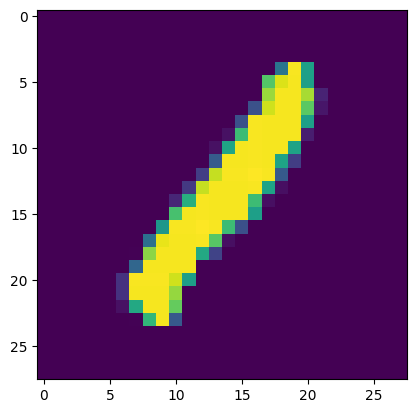

In [349]:
n = random.randint(0, len(x_train))
print(y_train[n].item())
plt.imshow(x_train[n])

In [350]:
x_train[0].shape

torch.Size([28, 28])

In [351]:
class MNISTClassifier(torch.nn.Module):
    def __init__(self, channels=8, kernel_size=5, stride=1, pool_size=2, pool_stride=2):
        super(MNISTClassifier, self).__init__()
        self.in_channels = 1  # MNIST pictures are grayscale 
        self.flatten = nn.Flatten()
# in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None
        self.pipeline = torch.nn.Sequential(
            nn.Conv2d(1, 8, 5, 1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(8, 16, 5, 1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(3, 3),
            nn.Flatten(),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        return self.pipeline(x)

In [352]:
classifier = MNISTClassifier()

[4.953807319907355e-07, 6.202574912017589e-12, 3.7076941339364566e-07, 4.162385280198633e-12, 0.999996542930603, 2.3193162945744916e-08, 1.9946828189176813e-08, 6.658016915572773e-10, 6.92428198112438e-11, 2.6571779017103836e-06]


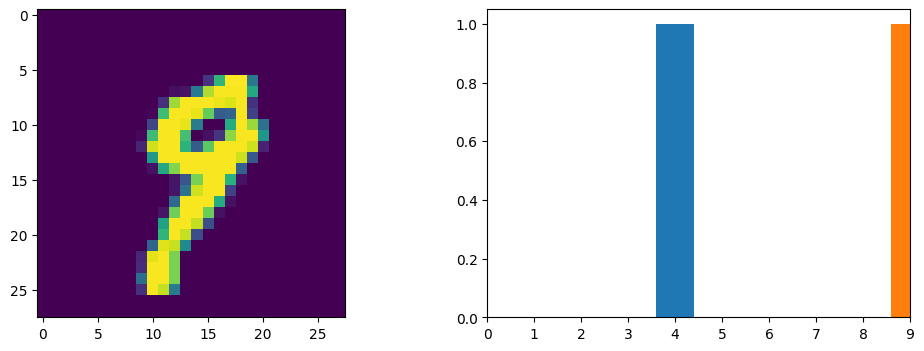

In [353]:
def predict_random_from_train(net: torch.nn.Module, apply_softmax=True): 
    with torch.no_grad():
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        n = random.randint(0, len(x_train))
        ax[0].imshow(x_train[n])
        y_sample = (net.forward(x_train[n].unsqueeze(0).unsqueeze(0))).squeeze()
        y_sample = softmax(y_sample) if apply_softmax else y_sample 

        ax[1].bar(x=torch.arange(10), height=y_sample)
        ax[1].bar(x=y_train[n], height=1)

        ax[1].set_xlim(0, 9)
        
    return y_sample


def predict_random_from_test(net: torch.nn.Module, apply_softmax=True): 
    with torch.no_grad():
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        n = random.randint(0, len(x_test))
        ax[0].imshow(x_test[n])
        y_sample = ((net.forward(x_test[n].unsqueeze(0).unsqueeze(0))).squeeze())
        y_sample = softmax(y_sample) if apply_softmax else y_sample 

        ax[1].bar(x=torch.arange(10), height=y_sample)
        ax[1].bar(x=y_test[n], height=1)

        ax[1].set_xlim(0, 9)
        
    return y_sample 

y_sample = predict_random_from_test(classifier, apply_softmax=True)
print(y_sample.tolist())

In [354]:
def predict(net: torch.nn.Module, x): 
    return net.forward(x.unsqueeze(1))

with torch.no_grad():
    print(softmax(predict(classifier, x_train).squeeze()))

tensor([[3.2246e-08, 1.5417e-10, 3.5772e-06,  ..., 1.7130e-08, 3.9355e-05,
         2.7683e-07],
        [5.7116e-13, 8.6402e-13, 1.7181e-08,  ..., 8.8611e-07, 1.0615e-10,
         2.7376e-09],
        [1.4623e-09, 1.1193e-04, 4.5015e-09,  ..., 1.8314e-06, 1.7396e-10,
         1.3162e-07],
        ...,
        [1.4162e-10, 8.6949e-10, 2.8173e-06,  ..., 3.8217e-08, 7.6561e-05,
         2.9384e-07],
        [1.3489e-12, 2.7787e-08, 1.3041e-06,  ..., 6.8079e-07, 2.0546e-08,
         1.3753e-07],
        [1.7857e-13, 4.0444e-08, 1.9931e-05,  ..., 4.6706e-09, 3.4765e-08,
         2.7839e-08]])


In [355]:
# Training 
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001, weight_decay=1e-2)
epochs_count = 20
loss = nn.CrossEntropyLoss()

train_loader = DataLoader(dataset_train, batch_size=512, shuffle=True, num_workers=2)

for epoch in range(0, epochs_count):
    epoch_loss = 0

    for x_batch, y_true_batch in train_loader:
        optimizer.zero_grad()
        logits = classifier.forward(x_batch)
        
        loss_val = loss(logits, y_true_batch)
        loss_val.backward()
        
        optimizer.step()
        epoch_loss += loss_val.item()

    epoch_loss /= train_loader.batch_size

    print(f'epoch {epoch}, loss {epoch_loss}')

epoch 0, loss 0.2730013523832895
epoch 1, loss 0.10375099210068583
epoch 2, loss 0.08317134054959752
epoch 3, loss 0.06922229452175088
epoch 4, loss 0.05963218060787767
epoch 5, loss 0.05274363642092794
epoch 6, loss 0.047995072236517444
epoch 7, loss 0.04511867428664118
epoch 8, loss 0.04246681142831221
epoch 9, loss 0.04091390717076138
epoch 10, loss 0.03975914184411522
epoch 11, loss 0.0389307150762761
epoch 12, loss 0.0380814263044158
epoch 13, loss 0.03730179100239184
epoch 14, loss 0.03686758689582348
epoch 15, loss 0.03649617220798973
epoch 16, loss 0.03585429668601137
epoch 17, loss 0.03555788117228076
epoch 18, loss 0.03537691765814088
epoch 19, loss 0.03502093878341839


In [381]:
# Counting accuracy
def calculate_accuracy():
    test_loader = DataLoader(dataset_test, batch_size=1, num_workers=2)
    with torch.no_grad():
        predicted = torch.argmax(classifier.forward(x_test.unsqueeze(1)), dim=1)
        accuracy = ((predicted == y_test).sum() / y_test.shape[0]).item()
    return accuracy
    
calculate_accuracy()

0.9625999927520752